<a href="https://colab.research.google.com/github/sunnyskydream/ML-practice/blob/main/1_4_Supervised_Learning_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Use of decision tree: Classifying an unknown sample
partition the training instances into purer sub groups

Purity measurs:
- Entropy(information gain): most common
- Gini(population diversity)
- misclassification error

Strengths
- comprehensible, relative easy to implement
- Flexible: linear or nonlinear and potentially complex relationships
- Very fast to run (to classify examples) with large data sets
- Good at handling missing values: just treat “missing” as a value – can become a good predictor

Weakness
- Bad at handling continuous data, good at categorical input and output(good at discrete variables, continuous attributes need to be discretized)

In [51]:
import numpy as np
import pandas as pd
import sklearn
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%precision 3

'%.3f'

In [52]:
#entropy
-(0.5 * np.log2(0.5) +0.5 * np.log2(0.5) )

#entropy close to 1 -> impure

1.000

In [53]:
-(0.001 * np.log2(0.001) +0.999 * np.log2(0.999) )
#entropy close to 0 -> pure

0.011

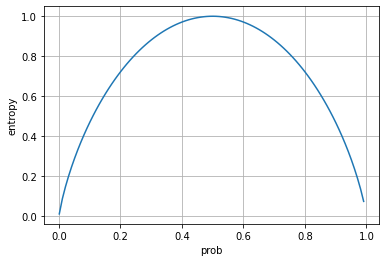

In [54]:
#plot entropy, 0 < p is probability < 1
def calc_entropy(p):
  return -(p * np.log2(p) + (1-p) * np.log2(1-p) ) 


p = np.arange(0.001, 0.999, 0.01)
plt.plot(p, calc_entropy(p))
plt.xlabel('prob')
plt.ylabel('entropy')
plt.grid(True)

##mushroom classification 
"From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible<br/>


This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like ``leaflets three, let it be'' for Poisonous Oak and Ivy."
https://archive.ics.uci.edu/ml/datasets/Mushroom

In [55]:
#load data
import requests, zipfile
import io

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
res = requests.get(url).content

mushroom = pd.read_csv(io.StringIO(res.decode('utf-8')), header = None)
mushroom.columns = ['classes','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']

mushroom.head()

,classes,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [56]:
print('mushroom.shape:{}'.format(mushroom.shape))
print('mushroom.isnull.sum(): {}'.format(mushroom.isnull().sum().sum()))

mushroom.shape:(8124, 23)
mushroom.isnull.sum(): 0


In [57]:
#set features within 'gill_color', 'gill_attachment, 'odor','cap_color'
#one-hot encoding/get_dummies()

mushroom_dummy = pd.get_dummies(mushroom[['gill-color','gill-attachment','odor','cap-color']])
mushroom_dummy.head()

,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,gill-attachment_a,gill-attachment_f,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y
0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [81]:
# flag target 0/1
mushroom_dummy['flg'] = mushroom['classes'].map(lambda x:1 if x =='p' else 0)
mushroom_dummy.head()
mushroom_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   gill-color_b       8124 non-null   uint8
 1   gill-color_e       8124 non-null   uint8
 2   gill-color_g       8124 non-null   uint8
 3   gill-color_h       8124 non-null   uint8
 4   gill-color_k       8124 non-null   uint8
 5   gill-color_n       8124 non-null   uint8
 6   gill-color_o       8124 non-null   uint8
 7   gill-color_p       8124 non-null   uint8
 8   gill-color_r       8124 non-null   uint8
 9   gill-color_u       8124 non-null   uint8
 10  gill-color_w       8124 non-null   uint8
 11  gill-color_y       8124 non-null   uint8
 12  gill-attachment_a  8124 non-null   uint8
 13  gill-attachment_f  8124 non-null   uint8
 14  odor_a             8124 non-null   uint8
 15  odor_c             8124 non-null   uint8
 16  odor_f             8124 non-null   uint8
 17  odor_l        

In [59]:
mushroom_dummy.groupby(['cap-color_c', 'flg'])['flg'].count().unstack() #unstack()https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html?highlight=unstack#pandas.DataFrame.unstack
#unuseful feature as cap-color_c = 0, has both change to be poison or edible

flg,0,1
cap-color_c,,
0,4176,3904
1,32,12


In [60]:
mushroom_dummy.groupby(['gill-color_b', 'flg'])['flg'].count().unstack()

flg,0,1
gill-color_b,,
0,4208.0,2188.0
1,NaN,1728.0


In [61]:
mushroom_dummy.groupby('flg')['flg'].count()

flg
0    4208
1    3916
Name: flg, dtype: int64

information gain for cap-color_c

In [62]:
entropy_init = -(0.518 * np.log2(0.518) +0.482 * np.log2(0.482 ))
print('entropy_init:{}'.format(entropy_init))

entropy_init:0.9990649315776107


In [63]:
mushroom_dummy.groupby(['cap-color_c', 'flg'])['flg'].count().unstack()

flg,0,1
cap-color_c,,
0,4176,3904
1,32,12


In [64]:
#cap-color_c = 0 
p1 = 4176/(4176+3904)
p2 = 1-p1
entropy_c0 =  -(p1* np.log2(p1) +p2 * np.log2(p2))
print('entropy_c0: {:.3f}'.format(entropy_c0))

entropy_c0: 0.999


In [65]:
#cap-color_c = 1
p1 = 32/(32+12)
p2 = 1-p1
entropy_c1 =  -(p1* np.log2(p1) +p2 * np.log2(p2))
print('entropy_c1: {:.3f}'.format(entropy_c1))

entropy_c1: 0.845


In [66]:
entropy_after = (4176+3904)/8124*entropy_c0 + (32+12)/8124 * entropy_c1
print('entropy_after:{:.3f}'.format(entropy_after))
print('information gain after split with cap-color_c:{:.3f}'.format(entropy_init - entropy_after))

entropy_after:0.998
information gain after split with cap-color_c:0.001


information gain for gill_color

In [67]:
mushroom_dummy.groupby(['gill-color_b', 'flg'])['flg'].count().unstack()

flg,0,1
gill-color_b,,
0,4208.0,2188.0
1,NaN,1728.0


In [68]:
#gill_color = 0 
p1 = 4208/(4208+2188)
p2 = 1-p1
entropy_g0 =  -(p1* np.log2(p1) +p2 * np.log2(p2))
print('entropy_g0: {:.3f}'.format(entropy_g0))

#gill_color = 1
p1 = 0/(0+1728)
p2 = 1-p1
entropy_g1 = p2 * np.log2(p2)
print('entropy_g1: {:.3f}'.format(entropy_g1))

#information gain
entropy_after = (4208+2188)/8124*entropy_g0 + (0+1728)/8124*entropy_g1
print('information gain after split with gill_color:{:.3f}'.format(entropy_init - entropy_after))

entropy_g0: 0.927
entropy_g1: 0.000
information gain after split with gill_color:0.269


In [88]:
#model fit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X = mushroom_dummy.drop('flg', axis =1)
y = mushroom_dummy['flg']

'''
#shape is mismatched
X_train, y_train, X_test, y_test = train_test_split(X, y, random_state = 0)

print(np.shape(X_train))
print(np.shape(y_train))

model = DecisionTreeClassifier(criterion = 'entropy', max_depth =5, random_state = 0)
model.fit(X_train, y_train)

print('train accuracy: {:.3f}'.format(model.score(X_train, y_train)))
print('test accuracy: {:.3f}'.format(model.score(X_test, y_test)))'''

"\n#shape is mismatched\nX_train, y_train, X_test, y_test = train_test_split(X, y, random_state = 0)\n\nprint(np.shape(X_train))\nprint(np.shape(y_train))\n\nmodel = DecisionTreeClassifier(criterion = 'entropy', max_depth =5, random_state = 0)\nmodel.fit(X_train, y_train)\n\nprint('train accuracy: {:.3f}'.format(model.score(X_train, y_train)))\nprint('test accuracy: {:.3f}'.format(model.score(X_test, y_test)))"

In [83]:
model = DecisionTreeClassifier(criterion = 'entropy', max_depth =5, random_state = 0)
model.fit(X, y)

print(' accuracy: {:.3f}'.format(model.score(X,y)))

 accuracy: 0.992


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


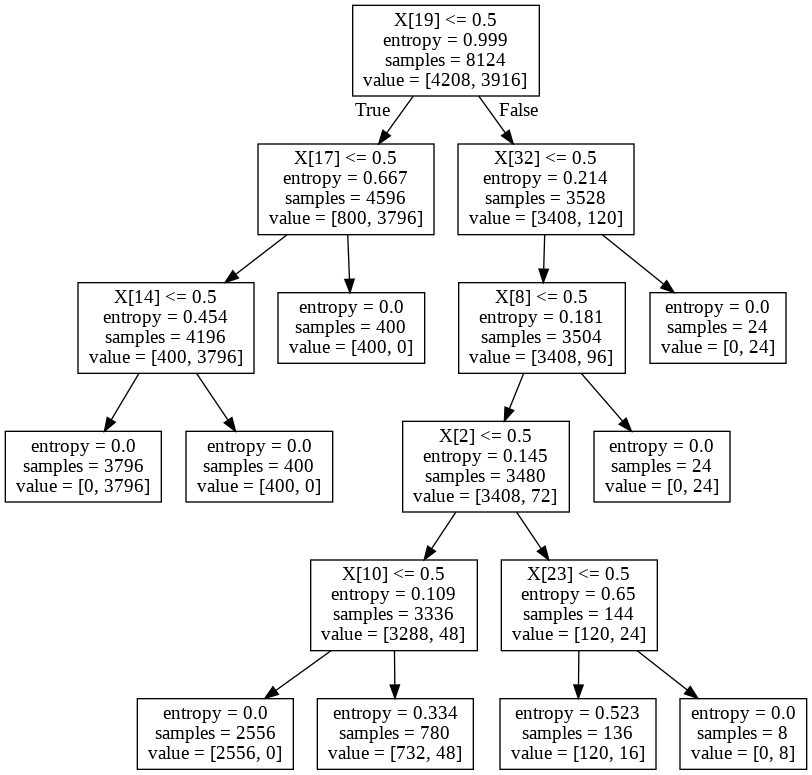

In [84]:
import graphviz
from sklearn import tree
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image

dot_data = StringIO()
tree.export_graphviz(model, out_file = dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())